In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy import stats

# Предположение распределения

$H_0$ - Цена имеет предполагаемое распределение (например, нормальное, логнормальное, экспоненциальное и т.д.)

$H_1$ - Цена не имеет предполагаемого распределения

Посмотрим через гистограмму как распределены данные

In [17]:
data = pd.read_csv('kc_house_data.csv')
scaled_data = data["price"] / 100000

poisson_lambda = scaled_data.mean()
shape, loc, scale = stats.lognorm.fit(scaled_data, floc=0)

print(f"Оцененные параметры:")
print(f"Пуассон лямбда = {poisson_lambda:.4f}")
print(f"Логнормальное: shape = {shape:.4f}, loc = {loc:.4f}, scale = {scale:.4f}")

Оцененные параметры:
Пуассон лямбда = 5.4009
Логнормальное: shape = 0.5267, loc = 0.0000, scale = 4.6408


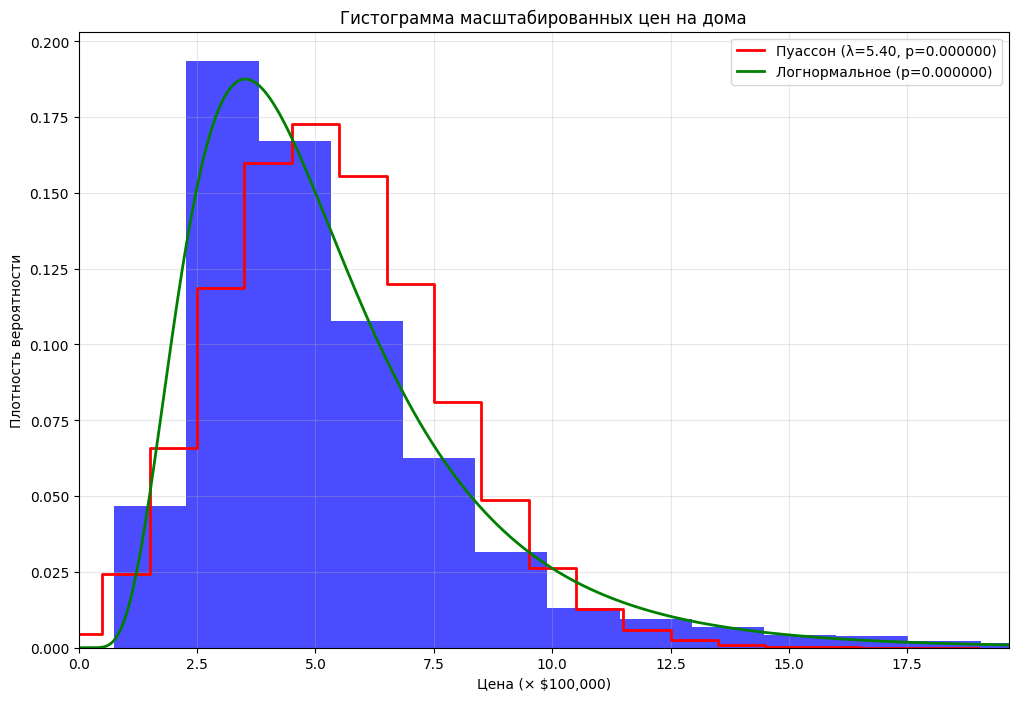

In [23]:
ks_poisson = stats.kstest(scaled_data, lambda x: stats.poisson.cdf(np.floor(x).astype(int), poisson_lambda))
ks_lognorm = stats.kstest(scaled_data, 'lognorm', args=(shape, loc, scale))

plt.figure(figsize=(12, 8))
hist_counts, hist_bins, _ = plt.hist(scaled_data, bins=50, alpha=0.7, color='blue', density=True)
plt.title('Гистограмма масштабированных цен на дома')
plt.xlabel('Цена (× $100,000)')
plt.ylabel('Плотность вероятности')
plt.grid(True, alpha=0.3)

x_limit = np.percentile(scaled_data, 99)
plt.xlim(0, x_limit)

x_values = np.linspace(0, x_limit, 1000)
int_x_values = np.arange(0, int(x_limit) + 1)

poisson_pmf_values = stats.poisson.pmf(int_x_values, poisson_lambda)
plt.step(int_x_values, poisson_pmf_values, 'r-', linewidth=2, where='mid',
         label=f'Пуассон (λ={poisson_lambda:.2f}, p={ks_poisson.pvalue:.6f})')

plt.plot(x_values, stats.lognorm.pdf(x_values, shape, loc, scale), 'g-', linewidth=2,
         label=f'Логнормальное (p={ks_lognorm.pvalue:.6f})')

plt.legend()
plt.show()


Заметим, что при предположении логнормального распределения или пуассоновского, они описывают хорошо на глаз гистограмму цен

Давайте теперь посмотрим куммулятивные функций распределений и выясним насколько они сильно отличаются от cdf

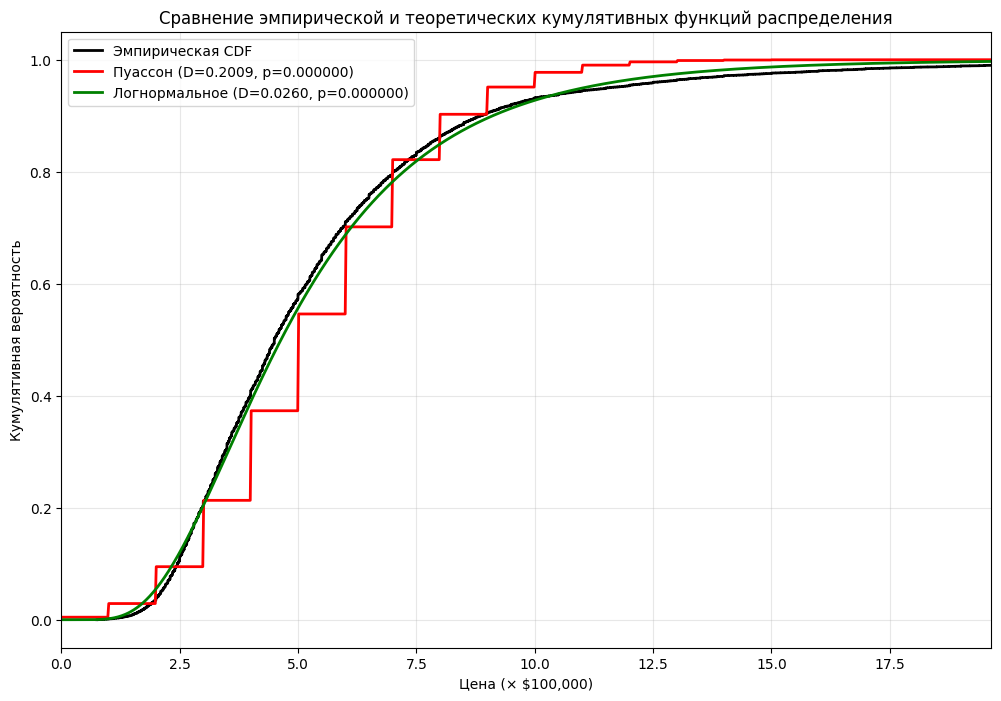

In [24]:
plt.figure(figsize=(12, 8))
sorted_data = np.sort(scaled_data)
ecdf_x = np.linspace(0, x_limit, len(sorted_data))
ecdf_y = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
plt.step(sorted_data, ecdf_y, 'k-', linewidth=2, label='Эмпирическая CDF')

plt.plot(x_values, stats.poisson.cdf(np.floor(x_values).astype(int), poisson_lambda), 'r-', 
         linewidth=2, label=f'Пуассон (D={ks_poisson.statistic:.4f}, p={ks_poisson.pvalue:.6f})')
plt.plot(x_values, stats.lognorm.cdf(x_values, shape, loc, scale), 'g-', linewidth=2,
         label=f'Логнормальное (D={ks_lognorm.statistic:.4f}, p={ks_lognorm.pvalue:.6f})')

plt.title('Сравнение эмпирической и теоретических кумулятивных функций распределения')
plt.xlabel('Цена (× $100,000)')
plt.ylabel('Кумулятивная вероятность')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(0, x_limit)
plt.show()

Видим, что пуассон достаточно плохо описывает cdf, по сравнению с логнормальным распределением. Давайте для большей точности рассмотрим разности между эмпирической и теоретической cdf

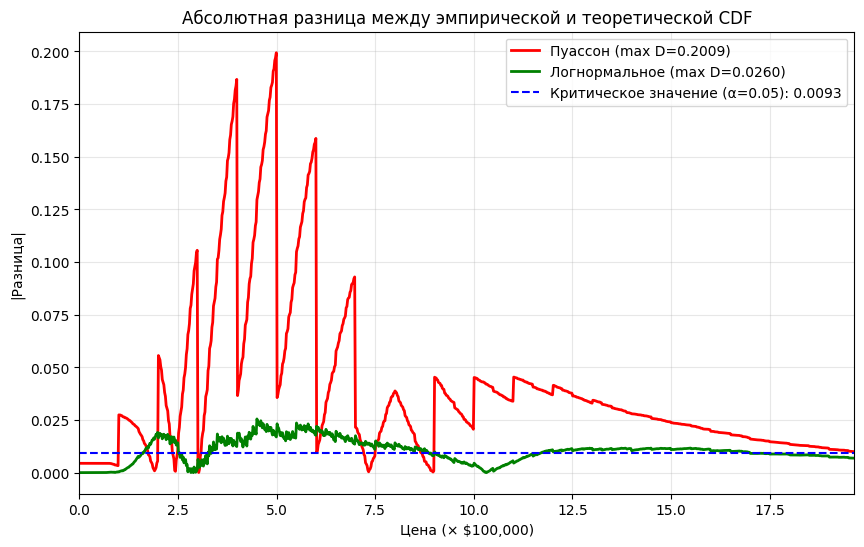

In [34]:
plt.figure(figsize=(10, 6))
ecdf_interp = np.interp(x_values, sorted_data, ecdf_y)
poisson_cdf_values = stats.poisson.cdf(np.floor(x_values).astype(int), poisson_lambda)
lognorm_cdf_values = stats.lognorm.cdf(x_values, shape, loc, scale)

plt.plot(x_values, np.abs(ecdf_interp - poisson_cdf_values), 'r-', linewidth=2,
         label=f'Пуассон (max D={ks_poisson.statistic:.4f})')
plt.plot(x_values, np.abs(ecdf_interp - lognorm_cdf_values), 'g-', linewidth=2,
         label=f'Логнормальное (max D={ks_lognorm.statistic:.4f})')


c_alpha = 1.36

critical_value = c_alpha / np.sqrt(len(scaled_data))
plt.axhline(y=critical_value, color='b', linestyle='--',
      label=f'Критическое значение (α=0.05): {critical_value:.4f}')

plt.title('Абсолютная разница между эмпирической и теоретической CDF')
plt.xlabel('Цена (× $100,000)')
plt.ylabel('|Разница|')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(0, x_limit)
plt.show()

In [37]:
print(f"\nРезультаты теста Колмогорова-Смирнова:")
print(f"Распределение Пуассона: D = {ks_poisson.statistic:.6f}, p-значение = {ks_poisson.pvalue:.10f}")
print(f"Логнормальное распределение: D = {ks_lognorm.statistic:.6f}, p-значение = {ks_lognorm.pvalue:.10f}")
print(f"Критическое значение (α=0.05): {critical_value:.6f}")

best_dist = "Пуассона" if ks_poisson.statistic < ks_lognorm.statistic else "логнормальное"
best_pvalue = max(ks_poisson.pvalue, ks_lognorm.pvalue)

print(f"\nНаилучшее соответствие: {best_dist} распределение")

if best_pvalue < 0.05:
    print("Обе модели отвергаются на уровне значимости 0.05")
else:
    print(f"Модель {best_dist} распределения не отвергается на уровне значимости 0.05")


Результаты теста Колмогорова-Смирнова:
Распределение Пуассона: D = 0.200929, p-значение = 0.0000000000
Логнормальное распределение: D = 0.025988, p-значение = 0.0000000000
Критическое значение (α=0.05): 0.009251

Наилучшее соответствие: логнормальное распределение
Обе модели отвергаются на уровне значимости 0.05


# Правда ли, что при увеличении "жилищной площади" растет и цена?

## Формулировка гипотез

$H_1$ - Есть статистическая зависимость между площадью и ценой

$H_0$ - $H_1$ неверна

## Выбор уровня значимости
$$\alpha =
0.05$$

## Первый тест

Тест на коэффициент корреляции Пирсона позволяет проверить численно зависимость между ценой и площадью (т.е. проверить гипотезу $H_1$)

$$
r = \frac{\sum (x - m_x) (y - m_y)}
                 {\sqrt{\sum (x - m_x)^2 \sum (y - m_y)^2}}
$$

## Второй тест
Тест Спирмена покажет направление и силу монотонной связи между ценой и площадью

Сначала с помощью МНК оценивается модель регрессии:
$$
y_t = x^T_t \cdot b + \varepsilon_t
$$

Далее ранжируем остатки $e_t$ и переменную $z_t$, от которой предполагается зависимость дисперсии случайных ошибок, и определяется коэффициент Спирмена:
$$
\rho = 1 - \frac{6 \cdot \sum d_t^2}{n(n^2-1)} 
$$ 

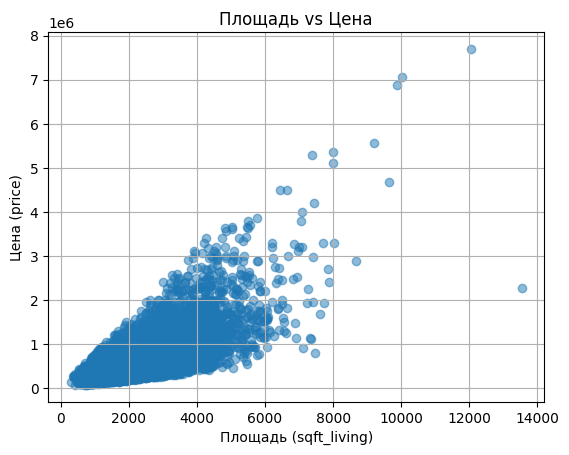

=== Первая часть: Тест на коэффициент корреляции Пирсона ===
Коэффициент корреляции r = 0.70204
P-value = 0.0
=> Отвергаем H_0: есть статистически значимая связь между площадью и ценой.

=== Вторая часть: Тест Спирмена ===
Коэффициент Спирмена ρ = 0.64419
P-value = 0.0
=> Отвергаем H_0: есть монотонная зависимость между площадью и ценой.


In [40]:
data = pd.read_csv('kc_house_data.csv')
sqft_living = data['sqft_living']
price = data['price']

alpha = 0.05

plt.scatter(sqft_living, price, alpha=0.5)
plt.title('Площадь vs Цена')
plt.xlabel('Площадь (sqft_living)')
plt.ylabel('Цена (price)')
plt.grid(True)
plt.show()

r, p_pearson = stats.pearsonr(sqft_living, price)
print("=== Первая часть: Тест на коэффициент корреляции Пирсона ===")
print(f"Коэффициент корреляции r = {r:.5f}")
print(f"P-value = {p_pearson}")

if p_pearson < alpha:
    print("=> Отвергаем H_0: есть статистически значимая связь между площадью и ценой.")
else:
    print("=> Нет оснований отвергнуть H_0: связи не обнаружено.")

rho, p_spearman = stats.spearmanr(sqft_living, price, alternative="greater")
print("\n=== Вторая часть: Тест Спирмена ===")
print(f"Коэффициент Спирмена ρ = {rho:.5f}")
print(f"P-value = {p_spearman}")

if p_spearman < alpha:
    print("=> Отвергаем H_0: есть монотонная зависимость между площадью и ценой.")
else:
    print("=> Нет оснований в отвержении H_0: монотонной зависимости не обнаружено.")


# Правда ли, что цена на старый и новый фонд распределена одинаково?


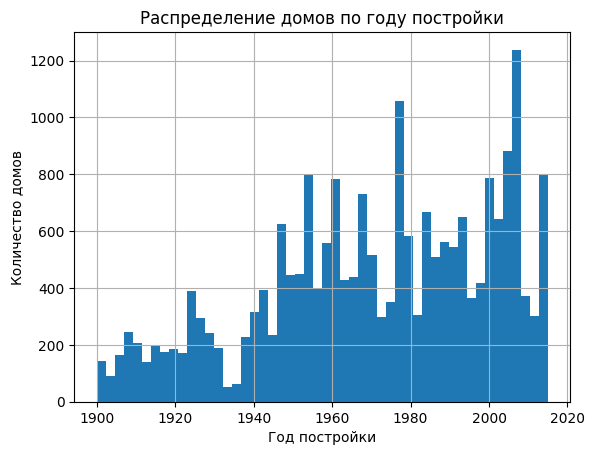

In [ ]:
data['yr_built'].hist(bins=50)
plt.xlabel('Год постройки')
plt.ylabel('Количество домов')
plt.title('Распределение домов по году постройки')
plt.show()

  На гистограмме видно, что до 1940 года количество построек было сравнительно небольшим и стабильным, тогда как после 1935 года начался заметный рост строительства.  
В связи с этим, в качестве порогового года был выбран 1940 год.

## Формулировка гипотез

$H_0$ - распределение цен на недвижимость одинаково для старого и нового фонда.

$H_1$ - распределения цен различаются между старым и новым фондом.

## Выбор уровня значимости
$$\alpha =
0.05$$

## Первый тест

Критерий Колмогорова для двух выборок позволяет проверить гипотезу о том, что обе выборки имеют одно и то же распределение. Статистика критерия определяется как:

$$
D = \sup_x |F_1(x) - F_2(x)|
$$

где $F_1(x)$ и $F_2(x)$ — эмпирические функции распределения выборок.

Критическое значение статистики рассчитывается по формуле:

$$
D_{\text{crit}} = c(\alpha) \times \sqrt{\frac{n_1 + n_2}{n_1 n_2}}
$$

где:
- $n_1$, $n_2$ — размеры выборок,
- $c(\alpha)$ — табличное значение, для уровня значимости $\alpha = 0.05$, $c(0.05) = 1.36$.


In [ ]:
old_fund = data[data['yr_built'] < 1935]['price']
new_fund = data[data['yr_built'] >= 1935]['price']

ks_statistic, ks_p_value = stats.ks_2samp(old_fund, new_fund)
print("Результаты критерия Колмогорова-Смирнова:")
print(f"D-статистика: {ks_statistic:.5f}")
print(f"P-value: {ks_p_value}")

if ks_p_value < 0.05:
    print("Вывод: Нулевая гипотеза отвергается.")
else:
    print("Вывод: Нет оснований отвергать нулевую гипотезу.")

t_statistic, t_p_value = stats.ttest_ind(old_fund, new_fund, equal_var=False)
print(f"\nРезультаты t-теста:")
print(f"t-статистика: {t_statistic:.5f}")
print(f"p-value: {t_p_value}")

if t_p_value < 0.05:
    print("Вывод: Нулевая гипотеза отвергается.")
else:
    print("Вывод: Нет оснований отвергать нулевую гипотезу.")


Результаты собственного расчёта:
D-статистика: 0.15215
Критическое значение: 0.02232
Приближённое p-value: 4.74159741407805e-75
Вывод: Нулевая гипотеза отвергается.
t-статистика: -15.02399
p-value: 3.36304624955411e-50
Вывод: Нулевая гипотеза отвергается.


# Выводы

В результате проведения критерия Смирнова приближённое значение $p$-value оказалось менее $0.00001$, что свидетельствует об отклонении нулевой гипотезы (о НЕзависимости цены и площади).

Для дополнительной проверки использовался t-тест для двух независимых выборок. С помощью него подтвердили, что средние значения цены для старого и нового фондов статистически значимо различаются.

Таким образом, можно заключить, что цена на недвижимость в старом и новом фонде распределена неодинаково.